MNIST for Crazy People
===

A simple convolutional network with 1 hidden weight layer.
Test set accuracy is approximately 99.5%, not state of the art, but pretty good for a shallow network with no data augmentation.

The network design is: do whatever Hinton & LeCun complain about, and what the Tensorflow doc warns us not to do:
1. A single hidden layer is a 9x9 convolution with a size 400 output channel.
1. A regularized softmax non-linear layer.
1. A 9x9 max pooling layer with stride 4.
1. A fully-connected readout layer.
1. A softmax layer (whose output we are going to pass to softmax_cross_entropy_with_logits!)

Actually, the choice of this network was a little more principled.

Feel free to contact michael.naunton@gmail.com with questions or suggestions.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

In [4]:
def dense(x, osz, name=None, with_w=False):
    isz = x.shape[-1].value
    with tf.variable_scope(name):
        matrix = tf.get_variable("w", 
                                 [isz, osz], 
                                 tf.float32, 
                                 tf.random_normal_initializer(stddev=0.02))
        bias = tf.get_variable("b", 
                               [osz], 
                               initializer=tf.constant_initializer(0.0))
        print('dense,  n vars:', isz*osz+osz)
        if with_w:
            return tf.matmul(x, matrix) + bias, (matrix, bias)
        else:
            return tf.matmul(x, matrix) + bias
        
def conv2d(x, osz, name, sz=5, stride=2, padding='SAME', with_w=False):
    isz = x.shape[-1].value
    with tf.variable_scope(name):
        w = tf.get_variable("w",
                            [sz,sz,isz,osz], 
                            initializer=tf.truncated_normal_initializer(stddev=0.02))
        b = tf.get_variable("b",
                            [osz], 
                            initializer=tf.constant_initializer(0.0))
        print('conv2d, n vars:', sz*sz*isz*osz+osz)
        conv = tf.nn.conv2d(x, w, strides=[1,stride,stride,1], padding=padding) + b
        if with_w:
            return conv, (w, b)
        else:
            return conv
    
def max_pool(x, sz=2, stride=2):
  return tf.nn.max_pool(x, ksize=[1, sz, sz, 1],
                        strides=[1, stride, stride, 1], padding='SAME')

def flatten(x):
    vs = [ d.value for d in x.shape ]
    s = 1
    for e in vs[1:]:
        s *= e
    return tf.reshape(x, [-1, s])

In [5]:
sess = tf.InteractiveSession()

In [6]:
sz = 9
hSz = 400
st = 4
sp = 1000

x2d = tf.reshape(x, [-1, 28, 28, 1])
c1 = conv2d(x2d, hSz, 'conv1', sz=sz, stride=1, padding='VALID') 
s = tf.nn.softmax(c1) 
m = max_pool(s, sz=sz, stride=st)

act = tf.reshape(m, (-1, hSz))
act_m = tf.reduce_mean(act, axis=0)
lumpy = tf.nn.moments(act_m, [0])[1]
s_cost = lumpy * sp

f = flatten(m)
d = dense(f, 10, 'ro') 
y = tf.nn.softmax(d)

cross_entropy      = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y) )
train_step         = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy+s_cost)
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


conv2d, n vars: 32800
dense,  n vars: 100010


In [7]:
def show(v, maxIms=1024, tSz=10, bg=.25, norm=True, border=2):
    if v.shape[0] > maxIms:
        v = v[:maxIms]
    if norm:
        mx = np.max(v, axis=None)
        mn = np.min(v, axis=None)
        v = (v-mn) / (mx-mn+.00001)
    if len(v.shape) == 3:
        v = v.reshape(v.shape+(1,))
    sz, y, x, c = v.shape
    h = int(sz**.5)
    w = (sz+h-1)//h
    plt.figure(figsize=(tSz, tSz))
    sx = x+border
    sy = y+border
    szX = border + w * sx
    szY = border + h * sy
    canvas = np.ones((szY, szX, c)) # canvas is h, w
    canvas = canvas * bg
    imInd = 0
    for _h in range(h):
        for _w in range(w):
            if imInd < sz:
                canvas[border+_h*sy: border+_h*sy+y, 
                       border+_w*sx: border+_w*sx+x, 
                       :] = v[imInd, :, :, : ]
                imInd += 1
    if c == 1:
        canvas = canvas.reshape(canvas.shape[:-1])
    p = plt.imshow(canvas, interpolation='none')
    p.set_cmap('gray')
    plt.axis('off')
    plt.show()

In [8]:
sess.run(tf.global_variables_initializer())

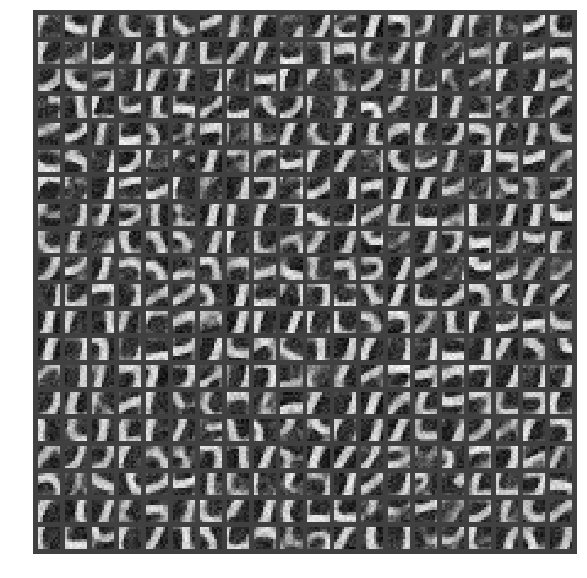


epoch      0  17.74  72.86  95.06  96.24  96.48  96.94  97.60  97.70  97.34  97.72 
epoch     10  98.46  98.08  98.30  98.34  98.54  98.24  98.52  98.38  98.40  98.42 
epoch     20  98.78  98.90  99.00  98.64  98.70  99.08  99.04  98.78  98.76  98.98 
epoch     30  99.12  98.98  98.90  99.28  99.32  99.48  99.14  99.24  99.38  99.10 
epoch     40  98.88  99.14  99.04  99.20  99.40  99.28  99.26  99.20  99.40  99.38 
epoch     50  99.36  99.52  99.46  99.42  99.48  99.42  99.62  99.42  99.50  99.48 
epoch     60  99.46  99.40  99.40  99.42  99.58  99.64  99.76  99.50  99.42  99.58 
epoch     70  99.68  99.62  99.52  99.60  99.50  99.48  99.50  99.74  99.68  99.64 
epoch     80  99.66  99.64  99.44  99.52  99.64  99.64  99.68  99.70  99.78  99.64 
epoch     90  99.80  99.64  99.78  99.58  99.52  99.60  99.54  99.66  99.76  99.74 


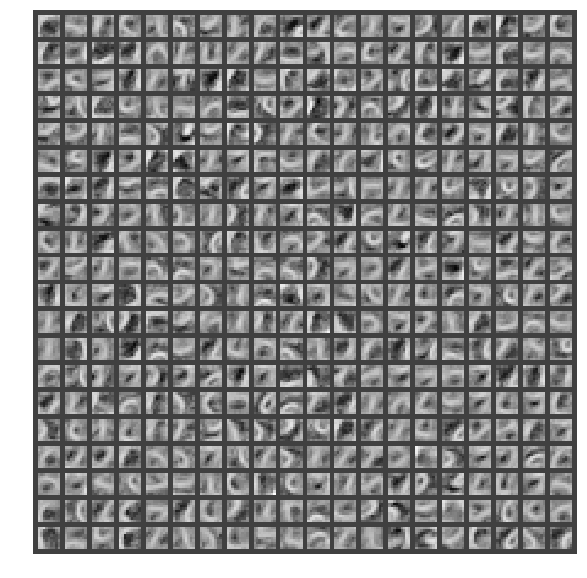


epoch    100  99.70  99.80  99.60  99.58  99.76  99.74  99.80  99.70  99.66  99.82 
epoch    110  99.66  99.82  99.72  99.92  99.78  99.66  99.62  99.76  99.80  99.68 
epoch    120  99.76  99.78  99.68  99.72  99.80  99.84  99.80  99.82  99.78  99.82 
epoch    130  99.80  99.74  99.86  99.90  99.84  99.88  99.66  99.74  99.70  99.84 
epoch    140  99.84  99.72  99.88  99.92  99.90  99.74  99.74  99.84  99.82  99.78 
epoch    150  99.78  99.86  99.80  99.88  99.88  99.86  99.82  99.84  99.78  99.80 
epoch    160  99.82  99.92  99.84  99.86  99.84  99.88  99.86  99.82  99.78  99.92 
epoch    170  99.82  99.82  99.92  99.92  99.84  99.78  99.94  99.92  99.80  99.82 
epoch    180  99.94  99.84  99.82  99.86  99.82  99.82  99.82  99.92  99.90  99.84 
epoch    190  99.96  99.84  99.84  99.84  99.94  99.90  99.84  99.70  99.88  99.90 


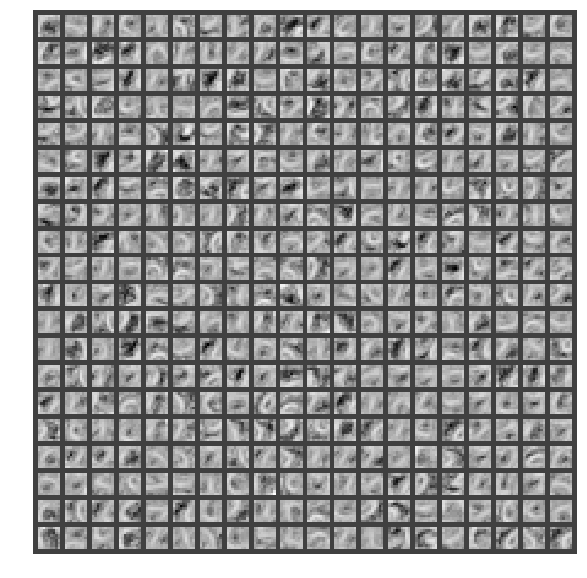


epoch    200  99.78  99.94  99.86  99.82  99.82  99.84  99.92  99.94  99.86  99.88 
epoch    210  99.86  99.88  99.88  99.94  99.88  99.84  99.88  99.80  99.88  99.88 
epoch    220  99.90  99.86  99.90  99.88  99.92  99.96  99.82  99.92  99.84  99.90 
epoch    230  99.78  99.90  99.88  99.98  99.94  99.78  99.84  99.94  99.90  99.90 
epoch    240  99.80  99.90  99.94  99.92  99.88  99.82  99.90  99.90  99.92  99.82 
epoch    250  99.90 
Test set accuracy: 0.995


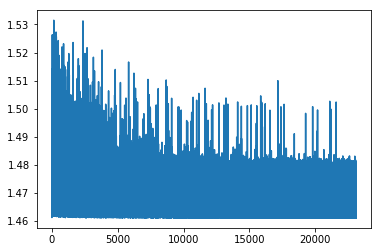

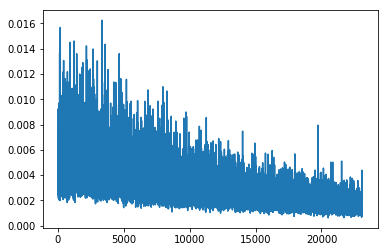

In [9]:
ce_sum = []

def train(nEpochs=251):
    for i in range(nEpochs):
        train_accuracy = 0

        for j in range(100):
            batch = mnist.train.next_batch(50)
            acc, ce, sc, _ = sess.run((accuracy, cross_entropy, s_cost, train_step), feed_dict={x: batch[0], y_: batch[1]})
            ce_sum.append((ce, sc))
            train_accuracy += acc
            
        if i % 100 == 0:
            print()
            with tf.variable_scope('conv1', reuse=True):
                w = tf.get_variable("w")
            v = sess.run(w)
            v = v.transpose(3,0,1,2)
            show(v)
            if 0:
                for i in range(len(ce_sum[0])):
                    plt.plot([ e[i] for e in ce_sum ])
                    plt.show()

        if i % 10 == 0:
            print()
            print('epoch %6d ' % i, end='')
        print("%6.2f " % (train_accuracy), end='')

    print()
    print('Test set accuracy:', sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

    for i in range(len(ce_sum[0])):
        plt.plot([ e[i] for e in ce_sum[2000:] ])
        plt.show()

train()

What we got wrong:
===

(50, 784)


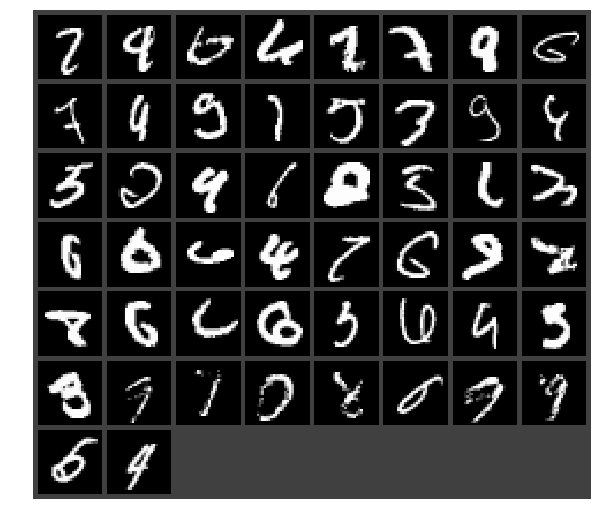

In [10]:
corr = sess.run(correct_prediction, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
errs = mnist.test.images[corr==False]
print(errs.shape)
show(errs.reshape(-1,28,28,1))

[[0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [2 1 0 0 0 0 0 2 0 0]
 [0 0 1 0 0 1 0 1 1 0]
 [0 0 0 0 0 0 0 0 1 2]
 [0 0 0 3 0 0 1 1 0 0]
 [4 2 0 0 3 2 0 0 2 0]
 [0 3 1 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 1 0 1]
 [0 0 0 0 4 2 0 3 1 0]]


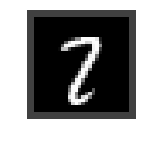

2 [  0   0 470   0   0   0   0 527   1   0]


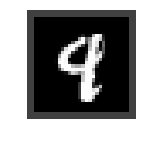

9 [  0   0   0   0 544   0   0   0   2 452]


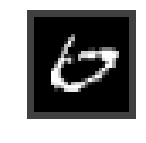

6 [978   0   0   0   0   0  21   0   0   0]


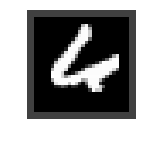

6 [  0   0   0   0 981   0  18   0   0   0]


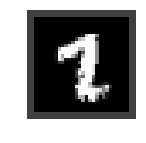

2 [  0 581 402   0   0   0   0  15   0   0]


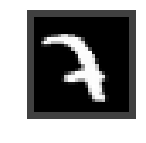

7 [  0   5 501  26   0   0   0 465   0   1]


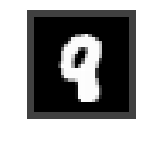

8 [  0   0   0   0   0   0   0   0 364 635]


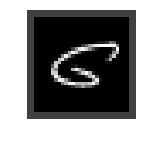

6 [ 54   0   0   0   0 923   6   0   8   6]


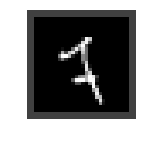

7 [  0 977   1   7   2   1   0   4   1   3]


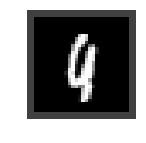

9 [  1   0   0   0 658   0   1   0   1 337]


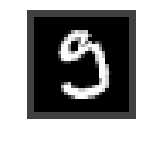

9 [  0   0   0   0   0 513   0   0   0 484]


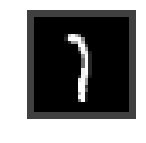

7 [  0 881   1   0   0   0   0 117   0   0]


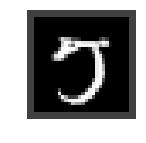

5 [  0   0   0   0   0 456   0 542   0   0]


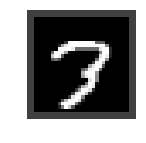

3 [  0   0   0 399   0   0   0 597   0   3]


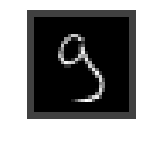

9 [  0   0   0  21   0 866   0   0  18  92]


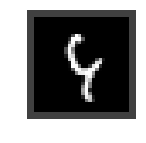

9 [  0   0   0   0 964   0   0   0   3  31]


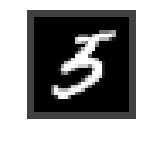

5 [  0   0   0 901   0  98   0   0   0   0]


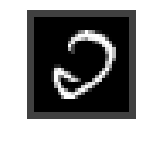

2 [874   0 125   0   0   0   0   0   0   0]


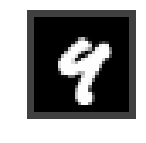

4 [  0   0   0   0   3   0   0   0   0 996]


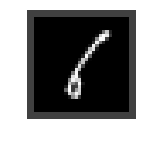

6 [  0 868   0   0   0   2  44   0  84   0]


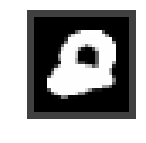

2 [785   0  17   0   0   0   0   0 196   0]


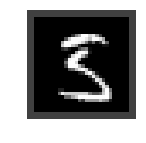

5 [  0   0   0 995   0   3   0   0   0   0]


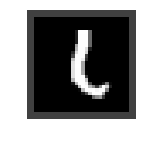

6 [  0 998   1   0   0   0   0   0   0   0]


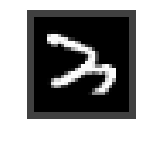

3 [  0   0 476 144   0   0   0 378   0   0]


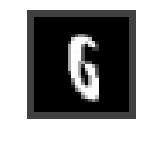

6 [  1   0   0   0   0   8 240   0 748   0]


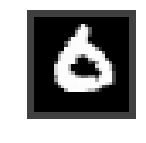

6 [972   0   0   0   0   0  26   0   0   0]


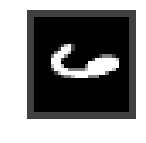

6 [  0   0   0   0 574   0 416   0   1   7]


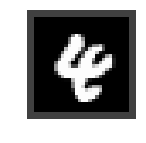

4 [  0   0   0   0 211   0   0   0 787   0]


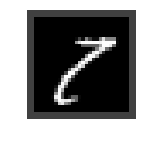

7 [  4   0   1   0   0   0   0  13 980   0]


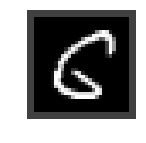

6 [877   0   0   0   0   0 117   0   4   0]


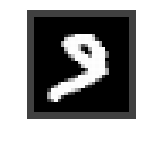

9 [  0   0 144   2   0   0   0   0 465 387]


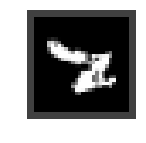

2 [  0   0  33   0   0   0   0 966   0   0]


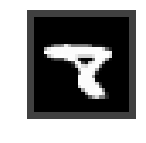

8 [  0   0   4   0   0   0   0 900  95   0]


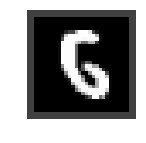

6 [  0   0   0   0   0 709 290   0   0   0]


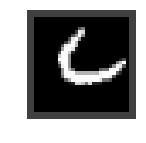

6 [  0   0   0   0 546   0 452   0   0   0]


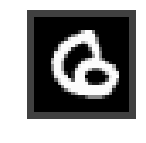

6 [273   0   0   0   0   0   2   0 722   0]


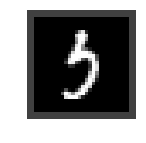

3 [  0   0   0  92   0 905   0   1   0   0]


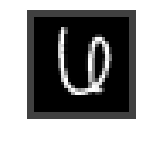

6 [729   0   0   0   0   0 270   0   0   0]


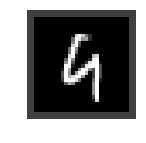

9 [  0   0   0   0 850   0  18   0   0 131]


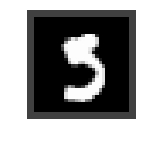

5 [  0   0   0 848   0 150   0   0   0   1]


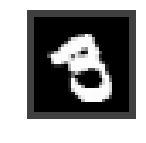

3 [  0   0   0 121   0   0   0   0 873   4]


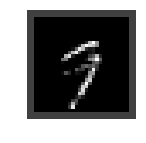

9 [  0   1   1  83   0   3   0 538   5 365]


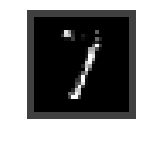

7 [  0 995   0   0   0   0   0   3   0   0]


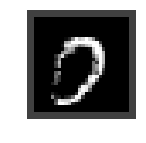

0 [  5   0   0   0   0   0   0 989   0   4]


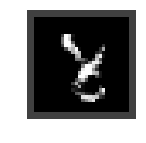

8 [  0 427 349   7   6   0   0   3 205   0]


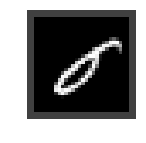

0 [370   0   2   0   0   0   8   0 618   0]


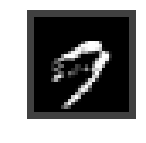

9 [  1   0   0  10   0   0   0 569   0 417]


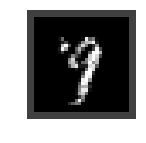

9 [  0   0   0   3   0   0   0 951   0  43]


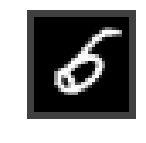

5 [  0   0   0   0   0   0 999   0   0   0]


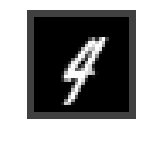

4 [  0   0   0   0 485   0   0   0   0 513]


In [11]:
corr, yy = sess.run((correct_prediction,y) , feed_dict={x: mnist.test.images, y_: mnist.test.labels})
errs = mnist.test.images[corr==False]
yy = yy[corr==False]
act = mnist.test.labels[corr==False]
errs = errs.reshape(-1,28,28,1)
missed = np.zeros((10,10)).astype(int)
for g, a in zip(yy, act):
    missed[np.argmax(a), np.argmax(g)] += 1
print(missed)
guesses = (yy*1000).astype(int)
for e, g, a in list(zip(errs, guesses, act))[:100]:
    show(e.reshape(1,28,28,1), tSz=2)
    print(np.argmax(a), g)